In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import cm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
['Flight Distance','Departure/Arrival time convenient','Departure Delay in Minutes','Arrival Delay in Minutes']

['Flight Distance',
 'Departure/Arrival time convenient',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

In [ ]:
np.percentile(df['Flight Distance'],25)
np.percentile(df['Flight Distance'],75)
iqr = np.percentile(df['Flight Distance'],75) - np.percentile(df['Flight Distance'],25)
lower_bound = np.percentile(df['Flight Distance'],25) - (1.5 * iqr)
upper_bound = np.percentile(df['Flight Distance'],75) + (1.5 * iqr)
print(lower_bound,upper_bound)

-1579.5 3736.5


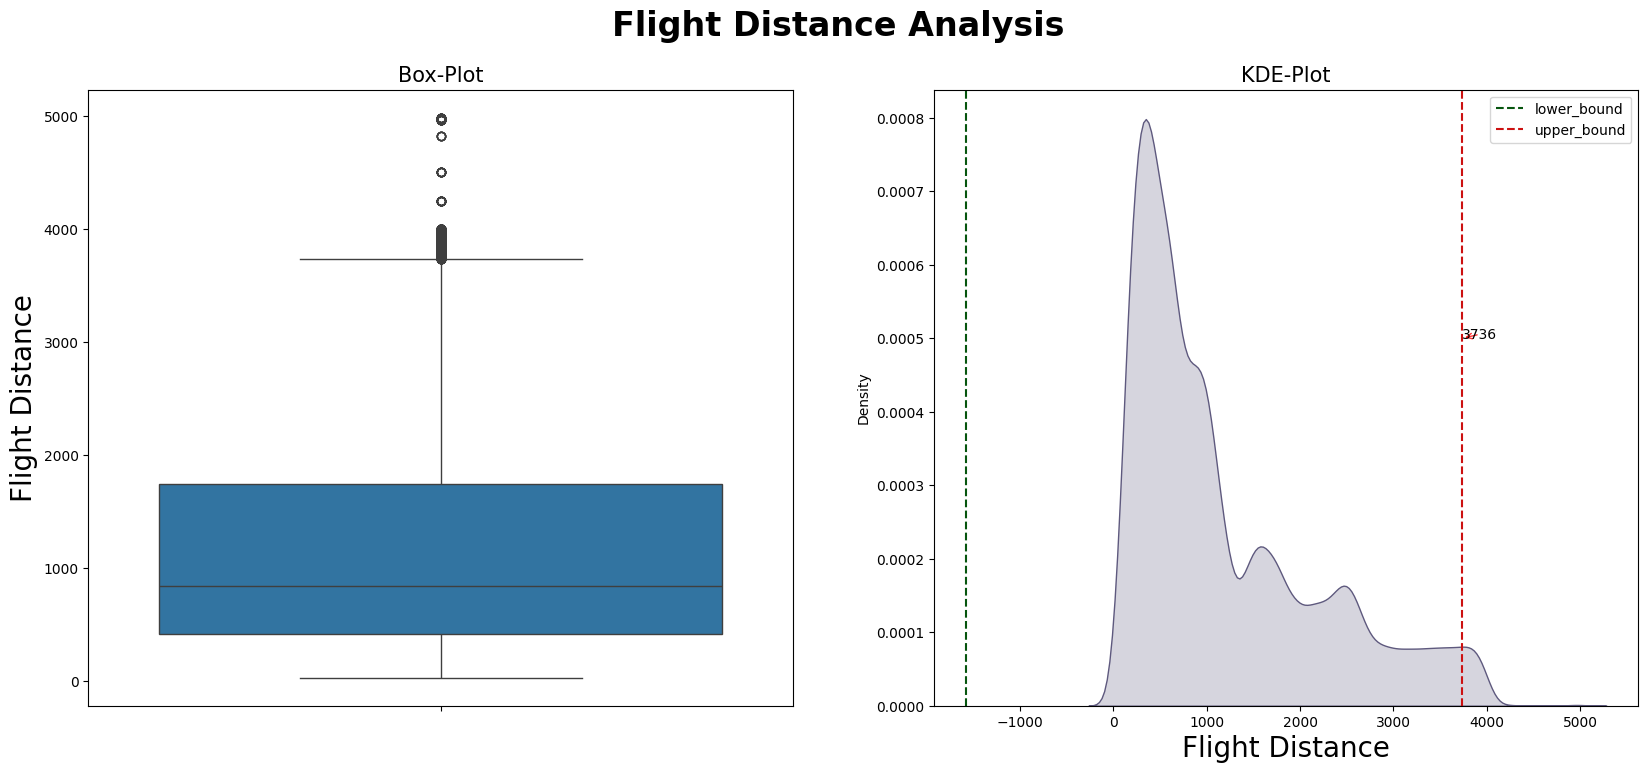

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
plt.suptitle('Flight Distance Analysis',fontsize=24,weight='bold')
ax1.set_title('Box-Plot',fontsize=15)
sns.boxplot(y='Flight Distance',data=df,ax=ax1)
ax1.set_ylabel('Flight Distance',fontsize=20)

ax2.set_title('KDE-Plot',fontsize=15)
sns.kdeplot(data=df, x='Flight Distance', ax=ax2, fill=True, color='#5e597e')
ax2.axvline(lower_bound,linestyle = '--',color = '#06550e',label='lower_bound')
ax2.axvline(upper_bound,linestyle = '--',color = '#cc1111',label='upper_bound')
ax2.legend()
ax2.set_xlabel('Flight Distance',fontsize=20)
ax2.annotate(f'{upper_bound:.0f}',xy={upper_bound,0.0005},arrowprops=dict(arrowstyle="->", color='r', alpha=.8))
plt.show()

In [ ]:
def percentile_ate_first_view(data,col,start,end,jump):

  for i in range(start,end,jump):
    var = data[col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
  print("100 percentile value is ",var[-1])

percentile_ate_first_view(df,'Flight Distance',90,100,1)

90 percentile value is 2750
91 percentile value is 2871
92 percentile value is 2994
93 percentile value is 3129
94 percentile value is 3256
95 percentile value is 3383
96 percentile value is 3510
97 percentile value is 3635
98 percentile value is 3762
99 percentile value is 3882
100 percentile value is  4983


In [ ]:
def percentile_ate_third_view(data,col):

  for i in np.arange(0.0,1.0,0.1):
    var = data[col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
  print("100 percentile value is ",var[-1])

percentile_ate_third_view(df,'Flight Distance')

99.0 percentile value is 3882
99.1 percentile value is 3893
99.2 percentile value is 3905
99.3 percentile value is 3919
99.4 percentile value is 3931
99.5 percentile value is 3943
99.6 percentile value is 3955
99.7 percentile value is 3968
99.8 percentile value is 3982
99.9 percentile value is 3995
100 percentile value is  4983


In [ ]:
df[df['Flight Distance']>3995]

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
994,994,59271,Female,Loyal Customer,26,Business travel,Business,4243,2,2,...,3,5,4,4,4,5,4,26,0.0,satisfied
2401,2401,59270,Female,Loyal Customer,25,Personal Travel,Eco,4963,2,5,...,5,3,4,4,2,3,2,0,0.0,neutral or dissatisfied
2847,2847,31870,Female,Loyal Customer,63,Personal Travel,Business,4983,0,5,...,3,2,4,3,1,5,1,3,0.0,satisfied
5903,5903,58704,Female,Loyal Customer,25,Business travel,Business,4243,4,5,...,3,2,3,4,4,4,4,4,0.0,neutral or dissatisfied
6617,6617,9824,Female,Loyal Customer,42,Business travel,Business,3996,2,3,...,2,2,2,2,1,2,2,0,0.0,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101612,101612,85227,Female,Loyal Customer,30,Business travel,Business,3998,3,3,...,4,4,4,1,2,1,4,0,0.0,satisfied
101664,101664,84499,Male,Loyal Customer,60,Personal Travel,Eco,4502,2,2,...,2,1,5,4,4,4,4,28,0.0,neutral or dissatisfied
102905,102905,21049,Female,Loyal Customer,36,Business travel,Business,3998,3,3,...,4,4,4,5,4,4,1,33,24.0,satisfied
102913,102913,58708,Male,Loyal Customer,33,Business travel,Eco Plus,4243,2,5,...,4,5,3,3,2,3,2,16,13.0,neutral or dissatisfied


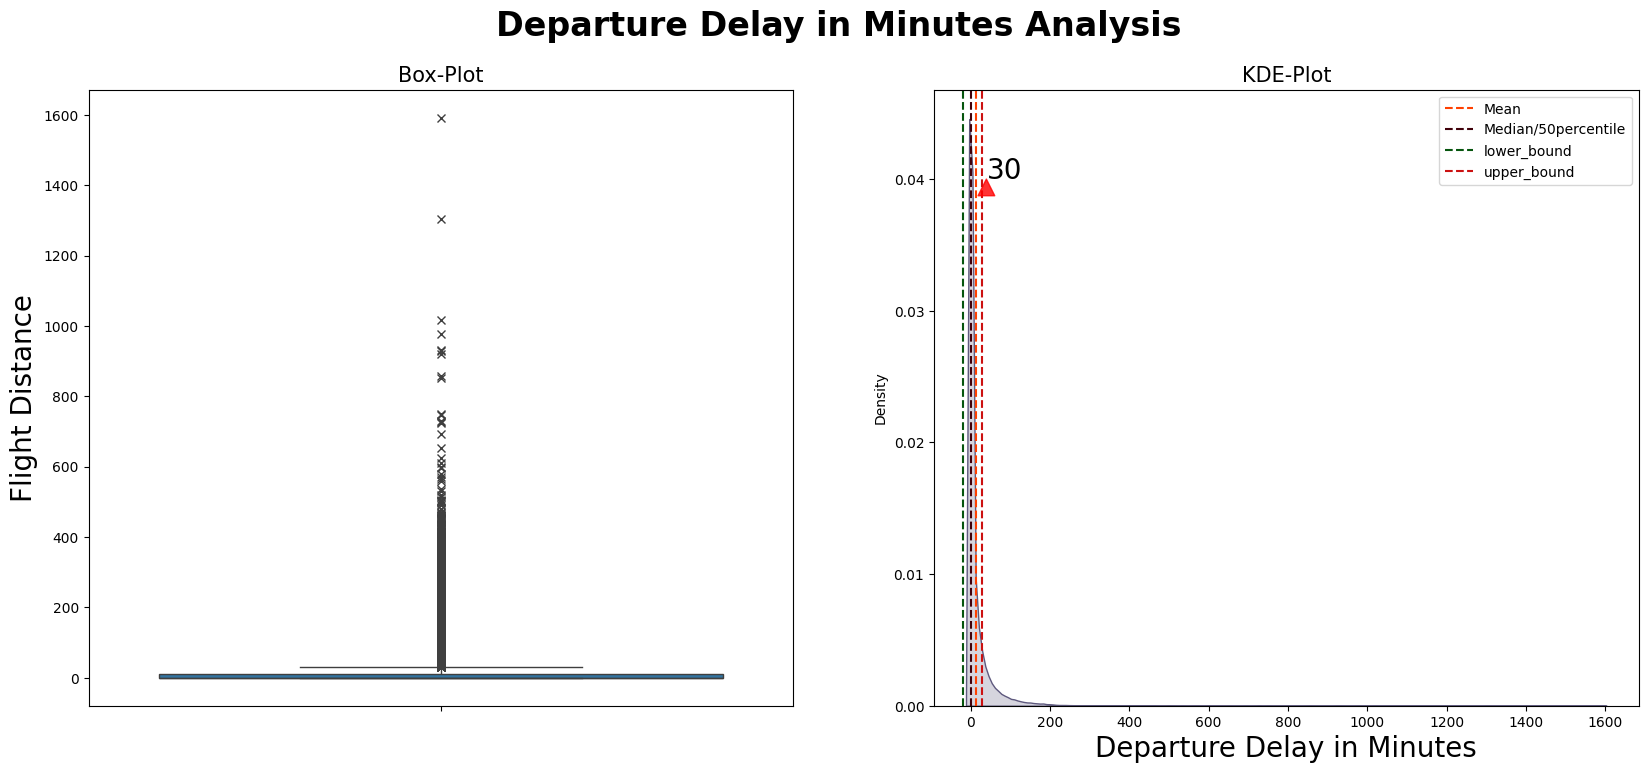

In [ ]:
def OutlierDetection(data,col):
  iqr = np.percentile(data[col],75) - np.percentile(data[col],25)
  lower_bound = np.percentile(data[col],25) - (1.5 * iqr)
  upper_bound = np.percentile(data[col],75) + (1.5 * iqr)
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
  plt.suptitle(col+' Analysis',fontsize=24,weight='bold')
  ax1.set_title('Box-Plot',fontsize=15)
  sns.boxplot(y=col,data=data,ax=ax1,flierprops={"marker": "x"})
  ax1.set_ylabel('Flight Distance',fontsize=20)

  ax2.set_title('KDE-Plot',fontsize=15)
  sns.kdeplot(data=data,x=col, ax=ax2, fill=True, color='#5e597e')
  ax2.axvline(df[col].mean(),linestyle = '--',color = '#ff4000',label='Mean')
  ax2.axvline(df[col].median(),linestyle = '--',color = '#40000a',label='Median/50percentile')
  ax2.axvline(lower_bound,linestyle = '--',color = '#06550e',label='lower_bound')
  ax2.axvline(upper_bound,linestyle = '--',color = '#cc1111',label='upper_bound')
  ax2.legend()
  ax2.set_xlabel(col,fontsize=20)
  ax2.annotate(f'{upper_bound:.0f}',xy={upper_bound+10,0.04},arrowprops=dict(color='r', alpha=.8),fontsize=20)
  plt.show()

OutlierDetection(df,'Departure Delay in Minutes')

In [ ]:
percentile_ate_first_view(df,'Departure Delay in Minutes',0,100,10)

0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 2
70 percentile value is 8
80 percentile value is 19
90 percentile value is 44
100 percentile value is  1592


In [ ]:
percentile_ate_third_view(df,'Departure Delay in Minutes')

99.0 percentile value is 182
99.1 percentile value is 187
99.2 percentile value is 196
99.3 percentile value is 204
99.4 percentile value is 215
99.5 percentile value is 233
99.6 percentile value is 253
99.7 percentile value is 279
99.8 percentile value is 315
99.9 percentile value is 376
100 percentile value is  1592


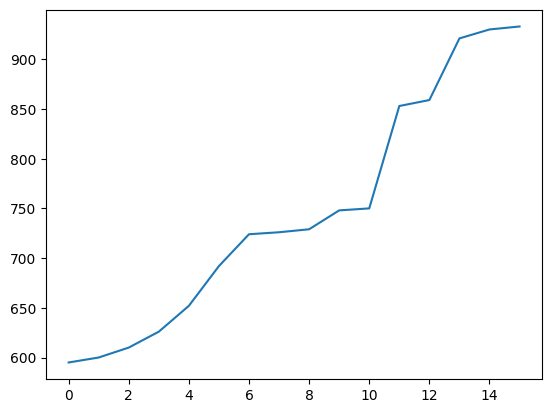

In [ ]:
var = df['Departure Delay in Minutes'].values
var = np.sort(var,axis = None)
plt.plot(var[-20:-4])
plt.show()

In [ ]:
df[df['Departure Delay in Minutes']>750]

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
6744,6744,69661,Male,Loyal Customer,32,Business travel,Business,2916,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied
27732,27732,69504,Male,Loyal Customer,27,Business travel,Business,1746,1,1,...,4,3,5,4,5,4,5,859,860.0,satisfied
51860,51860,79912,Male,Loyal Customer,15,Business travel,Business,3979,2,2,...,2,2,4,3,2,3,2,853,823.0,neutral or dissatisfied
61287,61287,4376,Female,Loyal Customer,53,Business travel,Business,2418,3,4,...,3,5,2,2,3,4,3,930,952.0,neutral or dissatisfied
61310,61310,4903,Male,Loyal Customer,49,Business travel,Business,1959,1,1,...,4,4,4,5,4,4,4,1017,1011.0,satisfied
61528,61528,83676,Male,disloyal Customer,43,Business travel,Business,577,3,3,...,5,4,5,5,5,3,5,921,924.0,neutral or dissatisfied
72206,72206,78300,Male,Loyal Customer,30,Personal Travel,Eco,1598,1,4,...,5,3,4,4,1,4,1,978,970.0,neutral or dissatisfied
80182,80182,8345,Male,Loyal Customer,47,Business travel,Business,2187,4,5,...,5,4,5,5,4,4,4,933,920.0,satisfied
83741,83741,73471,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,...,2,4,4,4,2,3,2,1592,1584.0,neutral or dissatisfied


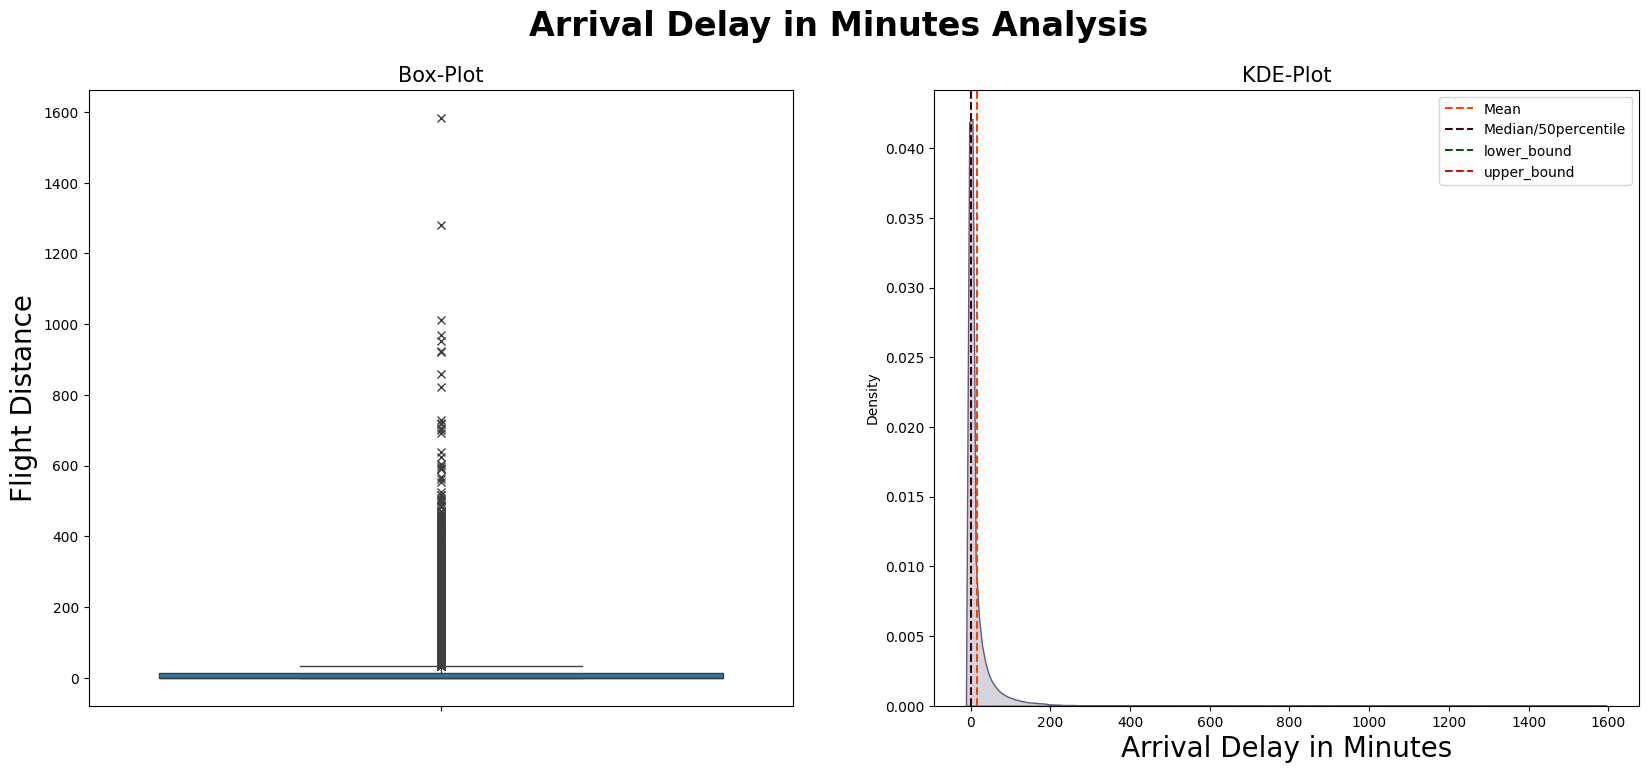

In [ ]:
OutlierDetection(df,'Arrival Delay in Minutes')

In [ ]:
percentile_ate_third_view(df,'Arrival Delay in Minutes')

99.0 percentile value is 183.0
99.1 percentile value is 189.0
99.2 percentile value is 198.0
99.3 percentile value is 209.0
99.4 percentile value is 221.0
99.5 percentile value is 238.0
99.6 percentile value is 257.0
99.7 percentile value is 283.0
99.8 percentile value is 319.0
99.9 percentile value is 383.0
100 percentile value is  1584.0


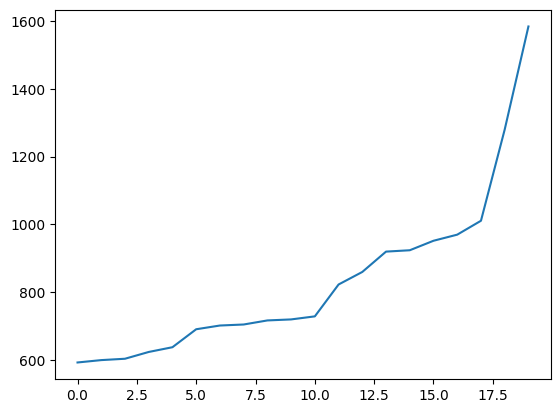

In [ ]:
var  = df['Arrival Delay in Minutes'].values
var = np.sort(var,axis = None)
plt.plot(var[-20:])
plt.show()

In [ ]:
df[df['Arrival Delay in Minutes']>1000]

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
6744,6744,69661,Male,Loyal Customer,32,Business travel,Business,2916,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied
61310,61310,4903,Male,Loyal Customer,49,Business travel,Business,1959,1,1,...,4,4,4,5,4,4,4,1017,1011.0,satisfied
83741,83741,73471,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,...,2,4,4,4,2,3,2,1592,1584.0,neutral or dissatisfied


In [ ]:
def remove_outlier(data):
  a=data.shape[0]
  print("{} are the number of rows we have in our original dataframe".format(a))
  new_dataframe=data[(data['Flight Distance']<3995) & (data['Departure Delay in Minutes']<750) & (data['Arrival Delay in Minutes']<1000)]
  b=new_dataframe.shape[0]
  print("Number of outlier:",(a-b))
  print("Percentage of data removed:",100-(b/a)*100)
  return new_dataframe

new_df = remove_outlier(df)

103904 are the number of rows we have in our original dataframe
Number of outlier: 115
Percentage of data removed: 0.11067908838928986


In [ ]:
df['Arrival Delay in Minutes'].isna().sum()
df['Arrival Delay in Minutes'].fillna(value=df['Arrival Delay in Minutes'].median(),inplace=True)
df.isnull().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [ ]:
new_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460.0,3.0,4.0,...,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235.0,3.0,2.0,...,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142.0,2.0,2.0,...,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562.0,2.0,5.0,...,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214.0,3.0,3.0,...,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,satisfied


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


# Convert categorical variables to numeric variables
# Label Encoder for categorical variables
lbl = preprocessing.LabelEncoder()
clms = ['Gender', 'Customer Type', 'Type of Travel', 'Class', "satisfaction"]
for x in clms:
    df[x] = lbl.fit_transform(df[x])

# Drop unnecessary columns
df.drop(["id", "Departure Delay in Minutes", "Arrival Delay in Minutes"], axis="columns", inplace=True)

# Define the features and the target
X = df.drop("satisfaction", axis="columns")
y = df["satisfaction"]

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)

# Create an instance of the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
model.fit(x_train, y_train)

# Use the model to make predictions on the unseen test data
y_predict = model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("Logistic Regression Accuracy:", accuracy)


Logistic Regression Accuracy: 0.7629084259660267


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

correlation_matrix = df.corr(method='pearson')["satisfaction"]
print(correlation_matrix)

Unnamed: 0                          -0.004731
Gender                               0.012211
Customer Type                       -0.187638
Age                                  0.137167
Type of Travel                      -0.449000
Class                               -0.449321
Flight Distance                      0.298780
Inflight wifi service                0.284245
Departure/Arrival time convenient   -0.051601
Ease of Online booking               0.171705
Gate location                        0.000682
Food and drink                       0.209936
Online boarding                      0.503557
Seat comfort                         0.349459
Inflight entertainment               0.398059
On-board service                     0.322383
Leg room service                     0.313131
Baggage handling                     0.247749
Checkin service                      0.236174
Inflight service                     0.244741
Cleanliness                          0.305198
satisfaction                      

In [ ]:
correlation_matrix_abs = correlation_matrix.abs()  # Get absolute values
sorted_corr = correlation_matrix_abs.sort_values(ascending=False)  # Sort descending

top_7_corr = sorted_corr.head(7)  # Select top 6 entries
top_7_cols = sorted_corr.index[:7].tolist()  # Get column names for top 6 correlations
top_corr_df = pd.DataFrame({'correlation': top_7_corr, 'column': top_7_cols})
print(top_corr_df)

                        correlation                  column
satisfaction               1.000000            satisfaction
Online boarding            0.503557         Online boarding
Class                      0.449321                   Class
Type of Travel             0.449000          Type of Travel
Inflight entertainment     0.398059  Inflight entertainment
Seat comfort               0.349459            Seat comfort
On-board service           0.322383        On-board service


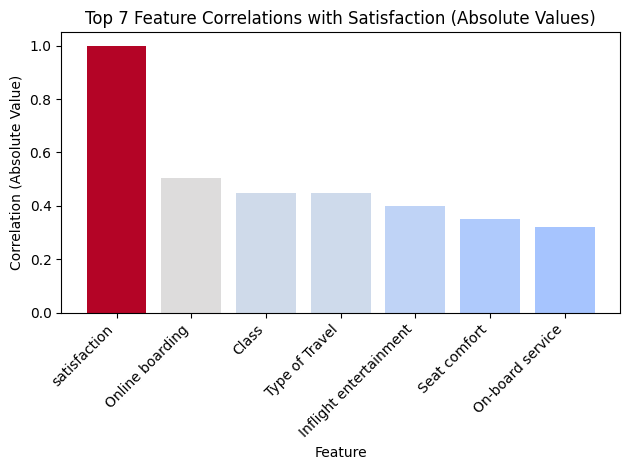

In [ ]:
# Extract correlation values and column names
correlations = top_corr_df['correlation'].to_numpy()
column_names = top_corr_df['column'].to_numpy()

# Color grading (adjust colormap and range as needed)
colors = plt.cm.get_cmap('coolwarm')(correlations)  # Colormap for positive/negative correlations

# Create the bar plot
plt.bar(column_names, correlations, color=colors)

# Customize the plot
plt.xlabel('Feature')
plt.ylabel('Correlation (Absolute Value)')
plt.title('Top 7 Feature Correlations with Satisfaction (Absolute Values)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

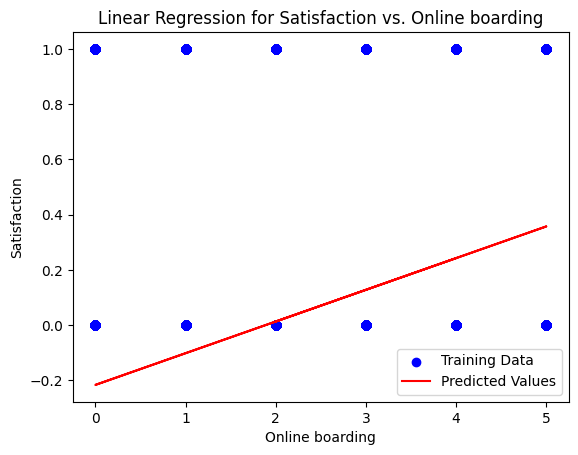

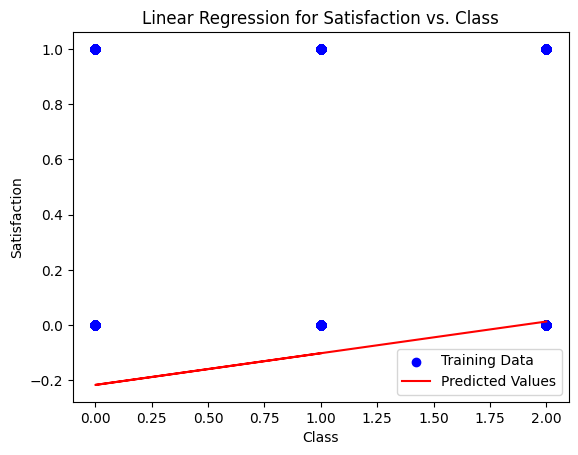

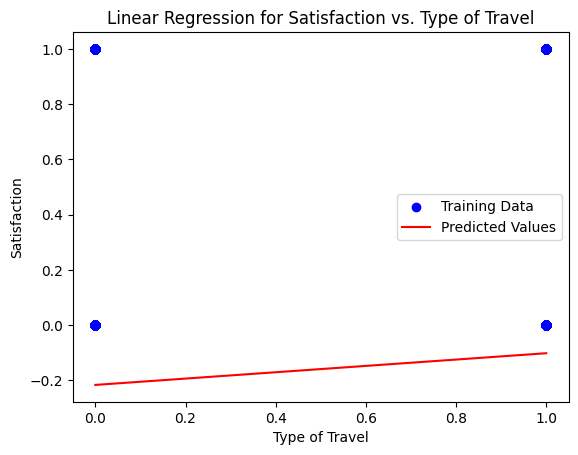

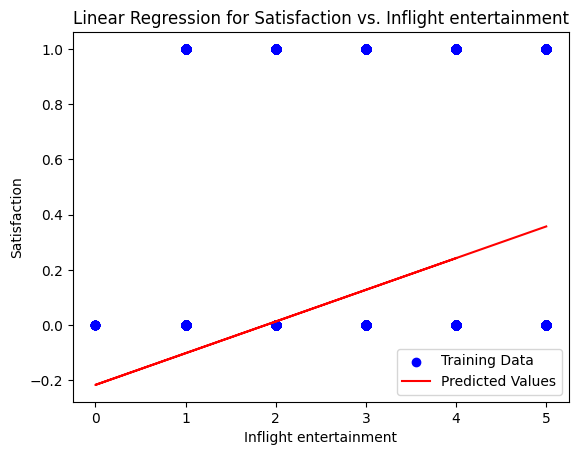

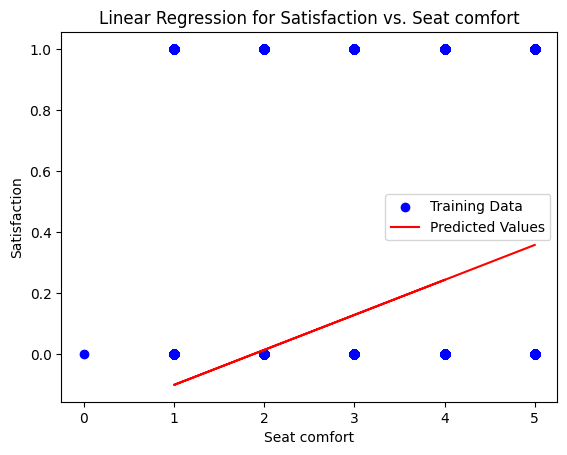

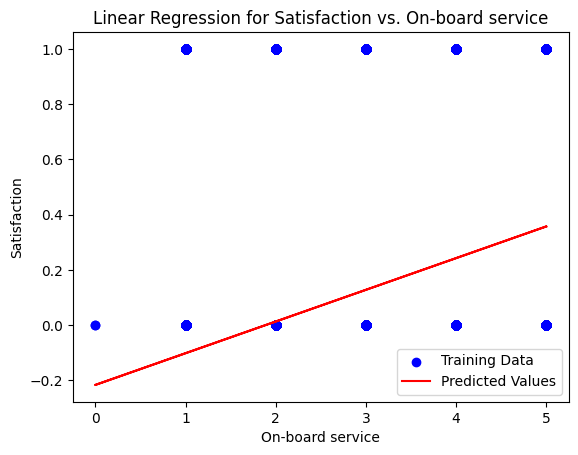

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assuming your DataFrame is named 'df'
top_6_cols = ['Online boarding', 'Class', 'Type of Travel', 'Inflight entertainment', 'Seat comfort', 'On-board service']  # Replace with actual feature names

def plot_linear_regression(feature):
  """
  Creates a linear regression graph for a given feature.

  Args:
      feature (str): The name of the feature to visualize.
  """

  # Select features and target variable
  X = df[top_6_cols]
  y = df['satisfaction']

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train the linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Extract feature values from training and testing sets
  feature_train = X_train[feature]
  feature_test = X_test[feature]

  # Get coefficients and intercept
  w = model.coef_[0]  # Coefficient for the selected feature
  b = model.intercept_

  # Calculate predicted values
  predicted_values = w * feature_test + b

  # Create the plot
  plt.scatter(feature_train, y_train, color='blue', label='Training Data')
  plt.plot(feature_test, predicted_values, color='red', label='Predicted Values')

  # Add labels and title
  plt.xlabel(feature)
  plt.ylabel('Satisfaction')
  plt.title('Linear Regression for Satisfaction vs. ' + feature)
  plt.legend()
  plt.show()

# Loop through each feature in top_6_cols and create visualizations
for feature in top_6_cols:
  plot_linear_regression(feature)


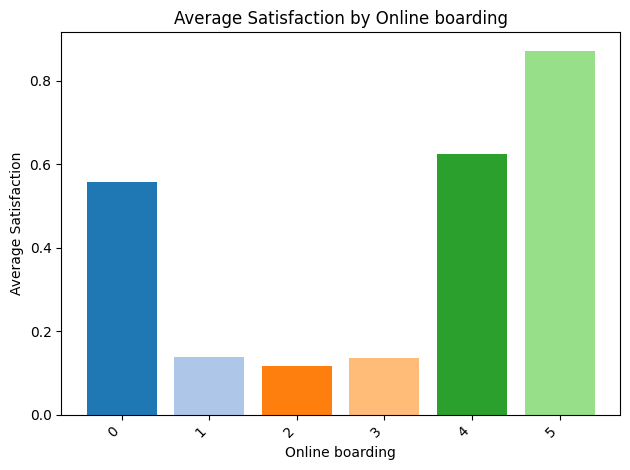

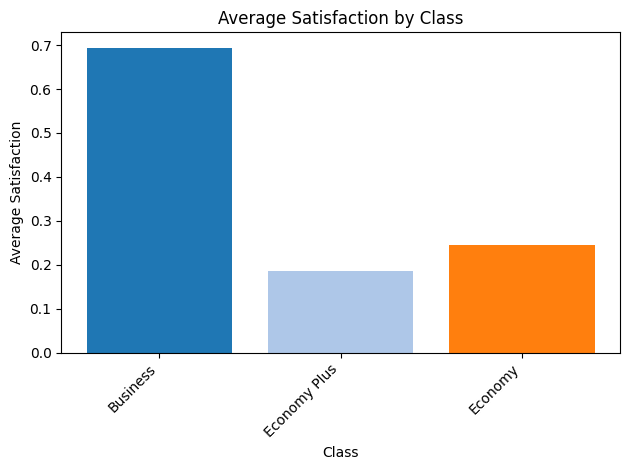

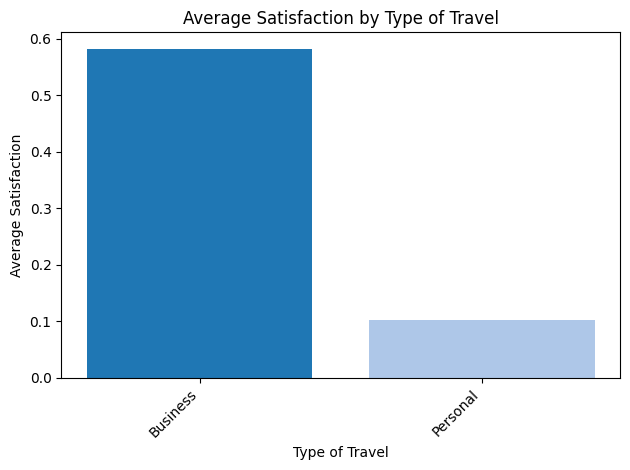

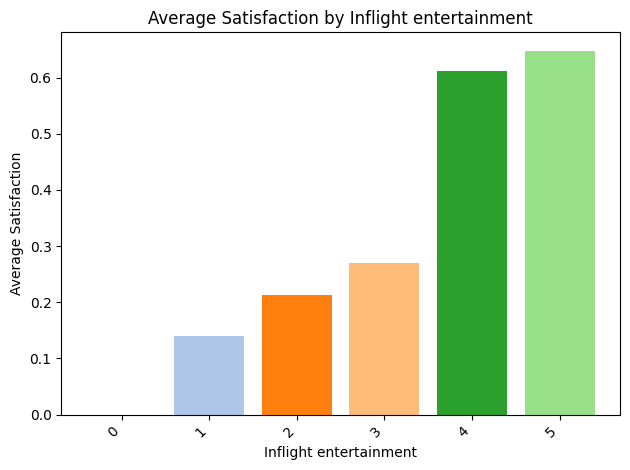

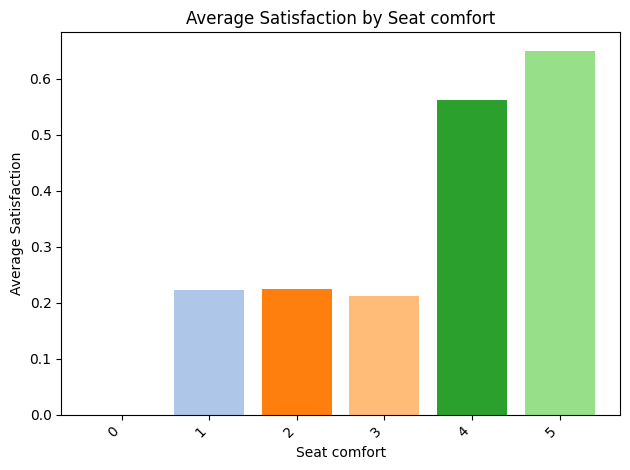

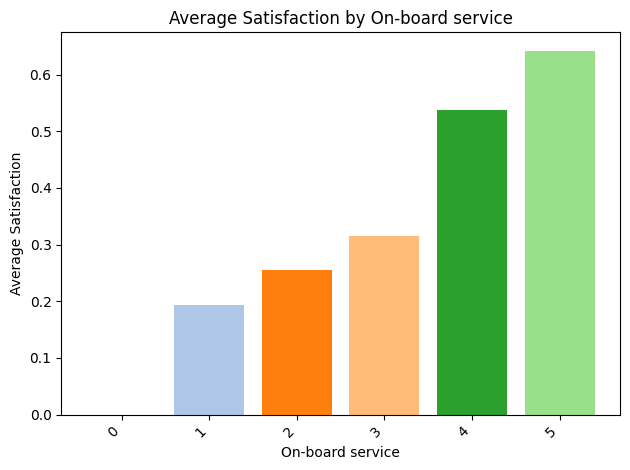

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
top_6_cols = ['Online boarding', 'Class', 'Type of Travel', 'Inflight entertainment', 'Seat comfort', 'On-board service']  # Replace with actual feature names

def combination_plot(feature):
  """
  Creates a bar graph for a given feature and satisfaction with different bar colors.

  Args:
      feature (str): The name of the feature to visualize.
  """

  # Define a colormap for generating unique colors
  cmap = plt.cm.get_cmap('tab20')  # Adjust colormap as needed

  # Calculate average satisfaction for each category of the feature
  df_average_satisfaction = df.groupby(feature)['satisfaction'].mean()
  feature_categories = df_average_satisfaction.index.to_numpy()

  # Map numerical labels to category names (optional)
  if feature == 'Class':
    category_map = {0: 'Business', 1: 'Economy Plus', 2: 'Economy'}  # Adjust mapping as needed
    feature_categories = [category_map[x] for x in feature_categories]
  elif feature == 'Type of Travel':
    category_map = {0: 'Business', 1: 'Personal'}  # Adjust mapping as needed
    feature_categories = [category_map[x] for x in feature_categories]

  average_satisfaction = df_average_satisfaction.to_numpy()
  num_categories = len(feature_categories)

  # Create the bar plot with unique colors
  bar_colors = cmap(range(num_categories))  # Generate colors based on the number of categories
  plt.bar(feature_categories, average_satisfaction, color=bar_colors)

  # Customize the plot
  plt.xlabel(feature)
  plt.ylabel('Average Satisfaction')
  plt.title('Average Satisfaction by ' + feature)
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability (optional)
  plt.tight_layout()
  plt.show()

# Loop through each feature in top_6_cols and create visualizations
for feature in top_6_cols:
  combination_plot(feature)